In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import product
from competition.titanic.FeaturesEngineering import *
import warnings
warnings.filterwarnings("error", category=FutureWarning)

from sklearn.pipeline import Pipeline

In [12]:
df = pd.read_csv("../data/train.csv", delimiter=",")

features = [x for x in df.columns if x != "Survived"]
x, y = df[features], df["Survived"].T
print(x.shape)
print(y.shape)

(891, 11)
(891,)


In [13]:
X_train, X_cv, y_train, y_cv = train_test_split(x, y, train_size=0.8, random_state=1)

In [14]:
print(f"X train: {X_train.shape}")
print(f"Y train: {y_train.shape}")
print(f"X cv: {X_cv.shape}")
print(f"y cv: {y_cv.shape}")


X train: (712, 11)
Y train: (712,)
X cv: (179, 11)
y cv: (179,)


In [15]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8]
min_samples_split_list = [30, 50, 100, 150, 200, 250, 300]
n_estimators_list = [50, 100, 150, 200]

In [16]:
# Verify the final features
feature_engineer = engineer_features()
X_transformed = feature_engineer.fit_transform(X_train)
names = feature_engineer.get_feature_names_out()
pd.DataFrame(X_transformed, columns=names).head()

,has_cabin__Cabin,decks__A,decks__B,decks__C,decks__D,decks__E,decks__F,decks__G,decks__T,decks__U,...,cat_variables__Embarked_C,cat_variables__Embarked_Q,cat_variables__Embarked_S,cat_variables__Embarked_nan,remainder__PassengerId,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,302.0,3.0,NaN,2.0,0.0,23.2500
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,310.0,1.0,30.0,0.0,0.0,56.9292
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,517.0,2.0,34.0,0.0,0.0,10.5000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,121.0,2.0,21.0,2.0,0.0,73.5000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,571.0,2.0,62.0,0.0,0.0,10.5000


In [17]:
def eval_models(X_train, y_train, X_cv, y_cv, max_depth, min_samples_split, n_estimators, feature_transformer):
    model = Pipeline(steps=[
        ("preprocessor", feature_transformer),
        ("classifier", RandomForestClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              random_state=1))
    ])
    model.fit(X_train, y_train)
    y_train_hat = model.predict(X_train)
    train_accuracy = np.mean(y_train_hat == y_train)
    y_cv_hat = model.predict(X_cv)
    cv_accuracy = np.mean(y_cv == y_cv_hat)
    print(
        f"Max depth: {max_depth}, Min sample split: {min_samples_split}, N estimators: {n_estimators}, Train accuracy: {train_accuracy}, CV accuracy: {cv_accuracy}")
    return model, max_depth, min_samples_split, n_estimators, train_accuracy, cv_accuracy


model_evals = [
    eval_models(X_train, y_train, X_cv, y_cv, max_depth, min_samples_split, n_estimators, engineer_features()) for
    max_depth, min_samples_split, n_estimators in product(max_depth_list, min_samples_split_list, n_estimators_list)]

best_model_params = max(model_evals, key=lambda x: x[5])
print(best_model_params[-5:])

Max depth: 2, Min sample split: 30, N estimators: 50, Train accuracy: 0.8075842696629213, CV accuracy: 0.7597765363128491
Max depth: 2, Min sample split: 30, N estimators: 100, Train accuracy: 0.7991573033707865, CV accuracy: 0.7430167597765364
Max depth: 2, Min sample split: 30, N estimators: 150, Train accuracy: 0.8075842696629213, CV accuracy: 0.7597765363128491
Max depth: 2, Min sample split: 30, N estimators: 200, Train accuracy: 0.8132022471910112, CV accuracy: 0.7541899441340782
Max depth: 2, Min sample split: 50, N estimators: 50, Train accuracy: 0.8075842696629213, CV accuracy: 0.7597765363128491
Max depth: 2, Min sample split: 50, N estimators: 100, Train accuracy: 0.7935393258426966, CV accuracy: 0.7374301675977654
Max depth: 2, Min sample split: 50, N estimators: 150, Train accuracy: 0.800561797752809, CV accuracy: 0.7430167597765364
Max depth: 2, Min sample split: 50, N estimators: 200, Train accuracy: 0.8047752808988764, CV accuracy: 0.7486033519553073
Max depth: 2, Min s

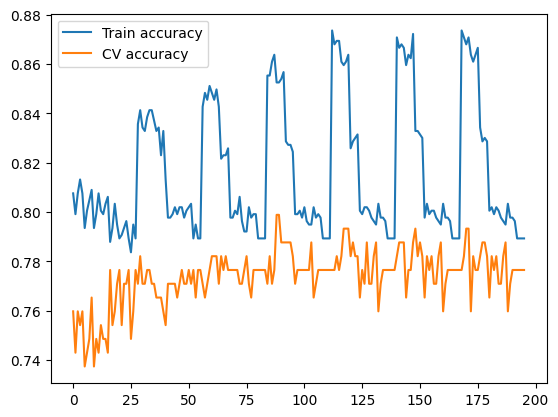

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
train_accuracy = [model[4] for model in model_evals]
cv_accuracy =[model[5] for model in model_evals]
plt.plot(range(len(model_evals)), train_accuracy)
plt.plot(range(len(model_evals)), cv_accuracy)
plt.legend(["Train accuracy", "CV accuracy", "Mean Accuracy"])
plt.show()

In [19]:
df_test = pd.read_csv("../data/test.csv", delimiter=",")

best_model = best_model_params[0]
y_test_hat = best_model.predict(df_test)
output = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_test_hat
})
output.to_csv("submission.csv", index=False)